In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from tqdm import trange
import warnings

from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectFromModel, SequentialFeatureSelector, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearnex import patch_sklearn, unpatch_sklearn

n_cpu = os.cpu_count()
seed = 24

warnings.filterwarnings('ignore')

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Load Data and Preprocessing

In [2]:
train_raw = pd.read_csv('./Data/train.csv')
print(train_raw.info())
test_raw = pd.read_csv('./Data/test.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  float64
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  float64
 5   dst_bytes                    125973 non-null  float64
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  float64
 8   urgent                       125973 non-null  float64
 9   hot                          125973 non-null  float64
 10  num_failed_logins            125973 non-null  float64
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  float64
 13 

In [3]:
col_drop = []
for col in train_raw.columns:
    if train_raw[col].value_counts().shape[0] == 1:
        col_drop.append(col)

print(col_drop)

['num_outbound_cmds']


In [4]:
train_X = train_raw.drop(['class', 'num_outbound_cmds'], axis=1).select_dtypes(include='number')
train_Y = train_raw['class'].map({'normal': 1, 'anomaly': 0})
test_X = test_raw.drop(['class', 'num_outbound_cmds'], axis=1).select_dtypes(include='number')
test_Y = test_raw['class'].map({'normal': 1, 'anomaly': 0})
test_X = (test_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
test_X = test_X.clip(0, 1)
train_X = (train_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
print(train_X.shape, test_X.shape)

(125973, 37) (22544, 37)


<Axes: >

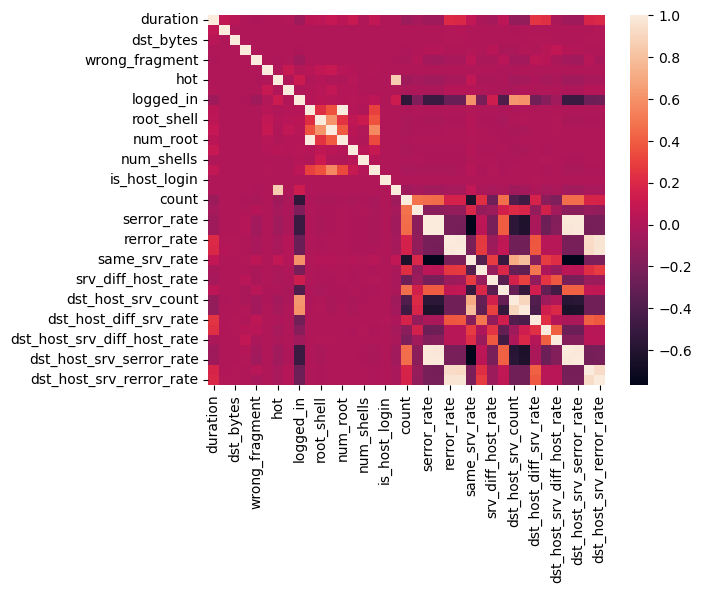

In [5]:
sns.heatmap(train_X.corr())

# Feature Selection

## Correlation-Based

In [5]:
correlation_matrix = train_X.corr()
model = RandomForestClassifier(n_estimators=200, n_jobs=n_cpu-1, random_state=seed)
selected_features = []

original_features = train_X.columns.tolist()
print(original_features)
start_time = time.time()
while len(original_features) > 0:
    indices = correlation_matrix[correlation_matrix.loc[:, original_features[0]] >= 0.8].index.tolist()
    print(indices)
    if len(indices) == 1:
        selected_features.append(indices[0])
        original_features.remove(indices[0])
        continue

    selector = SelectFromModel(model, threshold=-np.inf, max_features=1)
    selector.fit(train_X[indices], train_Y)
    selected_features.append([b for a, b in zip(selector.get_support(), indices) if a][0])
    original_features = [col for col in original_features if col not in indices]

print(f'time cost: {time.time()-start_time}')
print(f'selected features: {selected_features}')

train_X = train_X[selected_features]
test_X = test_X[selected_features]
print(train_X.shape, test_X.shape)

['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
['duration']
['src_bytes']
['dst_bytes']
['land']
['wrong_fragment']
['urgent']
['hot', 'is_guest_login']
['num_failed_logins']
['logged_in']
['num_compromised', 'num_root']
['root_shell']
['su_attempted']
['num_file_creations']
['num_shells']
['num_access_files']
['is_host_login']
['count']
['srv_count']
['serror_rate', 'srv_

# Greedy

In [11]:
start_time = time.time()

model = RandomForestClassifier(n_estimators=200, n_jobs=n_cpu-1, random_state=seed)

greedy_features = []
kf = StratifiedKFold(shuffle=True, random_state=seed)

selector = SelectKBest(mutual_info_classif, k='all')
selector.fit(train_X, train_Y)
sorted_index = np.argsort(-selector.scores_)
mi_features = train_X.columns[sorted_index].tolist()

for i in trange(train_X.shape[1]-1):
    candidates = []
    scores = []

    f = mi_features[0]
    candidates.append(f)
    cv = cross_val_score(model, train_X[greedy_features+[f]], train_Y, scoring='f1', cv=kf)
    scores.append(cv.mean())

    train_X2 = train_X.drop(greedy_features, axis=1)

    selector = SequentialFeatureSelector(model, n_features_to_select=1, direction='backward', scoring='f1', cv=kf)
    selector.fit(train_X2, train_Y)
    f = train_X2.columns[selector.get_support()][0]
    candidates.append(f)
    cv = cross_val_score(model, train_X[greedy_features+[f]], train_Y, scoring='f1', cv=kf)
    scores.append(cv.mean())

    selector = SelectFromModel(model, threshold=-np.inf, max_features=1)
    selector.fit(train_X2, train_Y)
    f = train_X2.columns[selector.get_support()][0]
    candidates.append(f)
    cv = cross_val_score(model, train_X[greedy_features+[f]], train_Y, scoring='f1', cv=kf)
    scores.append(cv.mean())

    best_feature_index = np.argmax(scores)
    best_feature = candidates[best_feature_index]
    greedy_features.append(best_feature)
    mi_features.remove(best_feature)

greedy_features.append(train_X.columns.drop(greedy_features)[0])
print(f'greedy ordered feature: {greedy_features}')
print(f'time cost: {time.time()-start_time}')

100%|██████████| 27/27 [11:59:52<00:00, 1599.72s/it]   

greedy ordered feature: ['same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_srv_rate', 'src_bytes', 'dst_bytes', 'dst_host_srv_serror_rate', 'count', 'diff_srv_rate', 'logged_in', 'dst_host_srv_diff_host_rate', 'dst_host_count', 'dst_host_same_src_port_rate', 'srv_diff_host_rate', 'dst_host_srv_rerror_rate', 'wrong_fragment', 'hot', 'num_compromised', 'duration', 'su_attempted', 'root_shell', 'land', 'is_host_login', 'srv_count', 'num_access_files', 'num_shells', 'num_file_creations', 'num_failed_logins', 'urgent']
time cost: 43210.163608789444


# Cross Validation / Test

In [16]:
def get_scores(model):
    cv_score = []
    test_score = []

    for i in trange(train_X.shape[1]):
        train_X2 = train_X[greedy_features[:i+1]].copy()
        cv = cross_val_score(model, train_X2, train_Y, scoring='f1', cv=kf)
        cv_score.append(cv.mean())

        model.fit(train_X2, train_Y)
        predict = model.predict(test_X[greedy_features[:i+1]])
        test_score.append(f1_score(test_Y, predict))

    print(f'time cost: {time.time()-start_time}')

    plt.plot(range(train_X.shape[1]), cv_score, color='blue', linestyle='-', label='CV Score')
    plt.plot(range(train_X.shape[1]), test_score, color='red', linestyle='-', label='Test Score')

    return cv_score, test_score

100%|██████████| 28/28 [01:13<00:00,  2.62s/it]

time cost: 339703.23691368103


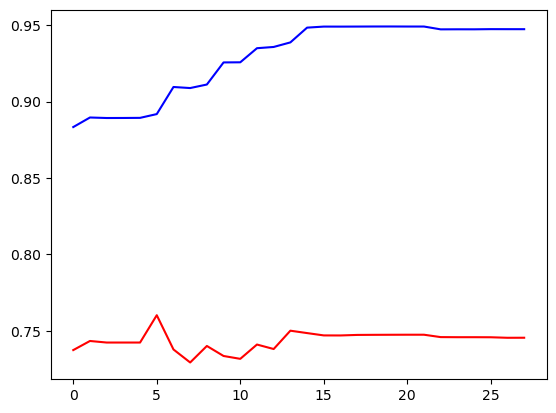

In [18]:
model = LogisticRegression(C=100, solver='liblinear', random_state=seed, n_jobs=n_cpu-1)
cv_score_LR, test_score_LR = get_scores(model)

100%|██████████| 28/28 [41:16<00:00, 88.44s/it] 

time cost: 342278.98937630653


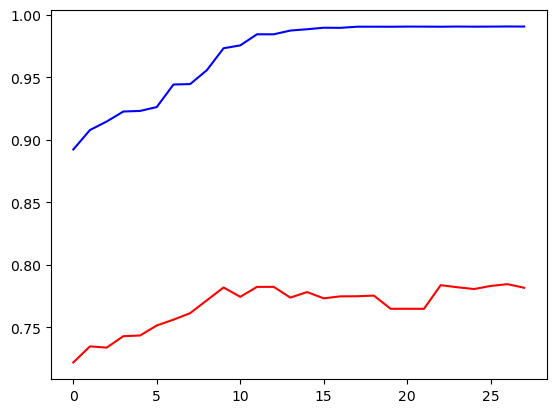

In [19]:
model = GradientBoostingClassifier(n_estimators=200, random_state=seed)
cv_score_GB, test_score_GB = get_scores(model)

In [8]:
import tensorflow as tf
import tensorflow.keras as keras

In [9]:
def create_model(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.Dense(50, activation='relu', input_shape=(input_shape,)))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.binary_crossentropy)
    return model

  0%|          | 0/28 [00:00<?, ?it/s]

705/705 [==============================] - 1s 1ms/step


  4%|▎         | 1/28 [07:15<3:15:56, 435.44s/it]

705/705 [==============================] - 1s 1ms/step


  7%|▋         | 2/28 [14:32<3:09:06, 436.41s/it]

705/705 [==============================] - 1s 1ms/step


 11%|█         | 3/28 [21:49<3:01:55, 436.63s/it]

705/705 [==============================] - 1s 1ms/step


 14%|█▍        | 4/28 [29:05<2:54:37, 436.57s/it]

705/705 [==============================] - 1s 1ms/step


 18%|█▊        | 5/28 [36:18<2:46:52, 435.31s/it]

705/705 [==============================] - 1s 1ms/step


 21%|██▏       | 6/28 [43:31<2:39:14, 434.30s/it]

705/705 [==============================] - 1s 1ms/step


 25%|██▌       | 7/28 [50:49<2:32:26, 435.53s/it]

705/705 [==============================] - 1s 1ms/step


 29%|██▊       | 8/28 [58:06<2:25:19, 435.96s/it]

705/705 [==============================] - 1s 1ms/step


 32%|███▏      | 9/28 [1:05:13<2:17:09, 433.12s/it]

705/705 [==============================] - 1s 1ms/step


 36%|███▌      | 10/28 [1:12:31<2:10:23, 434.66s/it]

705/705 [==============================] - 1s 1ms/step


 39%|███▉      | 11/28 [1:19:31<2:01:55, 430.31s/it]

705/705 [==============================] - 1s 1ms/step


 43%|████▎     | 12/28 [1:26:32<1:54:00, 427.53s/it]

705/705 [==============================] - 1s 1ms/step


 46%|████▋     | 13/28 [1:33:34<1:46:24, 425.61s/it]

705/705 [==============================] - 1s 1ms/step


 50%|█████     | 14/28 [1:40:35<1:38:59, 424.28s/it]

705/705 [==============================] - 1s 1ms/step


 54%|█████▎    | 15/28 [1:47:31<1:31:25, 421.94s/it]

705/705 [==============================] - 1s 1ms/step


 57%|█████▋    | 16/28 [1:54:32<1:24:19, 421.59s/it]

705/705 [==============================] - 1s 1ms/step


 61%|██████    | 17/28 [2:01:31<1:17:09, 420.85s/it]

705/705 [==============================] - 1s 1ms/step


 64%|██████▍   | 18/28 [2:08:32<1:10:07, 420.79s/it]

705/705 [==============================] - 1s 1ms/step


 68%|██████▊   | 19/28 [2:15:36<1:03:15, 421.76s/it]

705/705 [==============================] - 1s 1ms/step


 71%|███████▏  | 20/28 [2:22:36<56:10, 421.36s/it]  

705/705 [==============================] - 1s 1ms/step


 75%|███████▌  | 21/28 [2:29:48<49:31, 424.57s/it]

705/705 [==============================] - 1s 1ms/step


 79%|███████▊  | 22/28 [2:37:01<42:42, 427.05s/it]

705/705 [==============================] - 1s 1ms/step


 82%|████████▏ | 23/28 [2:44:14<35:43, 428.77s/it]

705/705 [==============================] - 1s 1ms/step


 86%|████████▌ | 24/28 [2:51:27<28:40, 430.09s/it]

705/705 [==============================] - 1s 1ms/step


 89%|████████▉ | 25/28 [2:58:40<21:32, 430.96s/it]

705/705 [==============================] - 1s 1ms/step


 93%|█████████▎| 26/28 [3:05:54<14:23, 431.97s/it]

705/705 [==============================] - 1s 1ms/step


 96%|█████████▋| 27/28 [3:13:10<07:12, 432.98s/it]

705/705 [==============================] - 1s 1ms/step


100%|██████████| 28/28 [3:20:21<00:00, 429.35s/it]


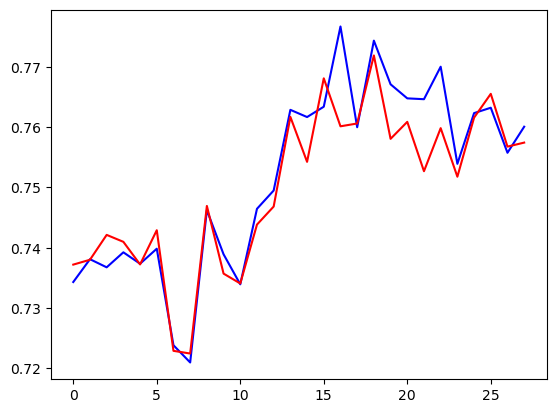

In [11]:
tf.random.set_seed(seed)

kf = StratifiedKFold(shuffle=True, random_state=seed)

cv_score_NN = []
test_score_NN = []

for k in trange(train_X.shape[1]):
    model = create_model(k+1)

    cv_score = []
    train_X2 = train_X[greedy_features[:k+1]].copy()
    for train_index, test_index in kf.split(train_X2, train_Y):
        x_train_fold, x_test_fold = train_X2.iloc[train_index, :], train_X2.iloc[test_index, :]
        y_train_fold, y_test_fold = train_Y.iloc[train_index], train_Y.iloc[test_index]

        model.fit(x_train_fold.values, y_train_fold.values,
                  epochs=15, batch_size=100,
                  use_multiprocessing=True, verbose=0)
        
        predict = model.predict(test_X[greedy_features[:k+1]], use_multiprocessing=True)
        predict = np.where(predict < 0.5, 0, 1)
        cv_score.append(f1_score(test_Y, predict))
    cv_score_NN.append(np.mean(cv_score))

    model.fit(train_X2.values, train_Y.values,
            epochs=15, batch_size=100,
            use_multiprocessing=True, verbose=0)
    predict = model.predict(test_X[greedy_features[:k+1]], use_multiprocessing=True)
    predict = np.where(predict < 0.5, 0, 1)
    test_score_NN.append(f1_score(test_Y, predict))

plt.plot(range(train_X.shape[1]), cv_score_NN, color='blue', linestyle='-', label='CV Score')
plt.plot(range(train_X.shape[1]), test_score_NN, color='red', linestyle='-', label='Test Score')

In [13]:
results = pd.DataFrame({'features': greedy_features,
                        'cv_score_LR': cv_score_LR,
                        'test_score_LR': test_score_LR,
                        'cv_score_GB': cv_score_GB,
                        'test_score_GB': test_score_GB,
                        'cv_score_NN': cv_score_NN,
                        'test_score_NN': test_score_NN})
results.to_csv('./Experiments/greedy.csv', index=False)